# Machine Learning Models

This is the notebook where the work that I've done so far culminates into a product. In this notebook I attempt to build a superior model given the lessons learned from exploratory data analysis, the new features I've created, the feature investigation and selection processes, and apply this work to make predictions to whether a loan applicant will default or not.   

In [1]:
from typing import Optional

import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
import phik
import shap
from optuna import Trial, TrialPruned, create_study
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import RandomSampler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import SelectPercentile, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from utils.feature_tools import (
    correlation_threshold,
    drop_least_target_correlated_features,
    get_columns_by_cardinality,
)
from utils.machine_learning import (
    concatenate_model_scores,
    general_preprocessing,
    model_assessment,
)
from utils.plot import conf_mat_plot, plot_pr_curve, plot_roc_curve
from utils.utils import reduce_mem_usage

In [2]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
pd.set_option("display.float_format", lambda x: f"{x:.5f}")

__Import Data__

In [3]:
%store -r y_train
y_train = y_train.copy()
%store -r y_val
y_val = y_val.copy()
%store -r y_test
y_test = y_test.copy()

In [4]:
X_train = pd.read_pickle("../data/merged_data/X_train_full.pkl")

In [5]:
X_val = pd.read_pickle("../data/merged_data/X_val_full.pkl")

In [6]:
X_test = pd.read_pickle("../data/merged_data/X_test_full.pkl")

In [7]:
kaggle_X_test = pd.read_pickle("../data/merged_data/kaggle_X_test_full.pkl")

__Pre-process Data__

In [8]:
X_train = general_preprocessing(X_train)
X_val = general_preprocessing(X_val)
X_test = general_preprocessing(X_test)
kaggle_X_test = general_preprocessing(kaggle_X_test)

# General Pipeline Instantiation

In this notebook you will see me write a series of functions that are designed into interact with [Optuna](www.optuna.org), a hyperparameter optimization framework. Throughout this notebook I was inspired by the blog of [Walter Sperat](https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451) to attempt to adopt his workflow and see how it would work for me. In general, this was an experiment for me to see if I could use this framework to write clean code and set myself up for efficient hyperparameter tuning later in the notebook. It also allowed me to approach each model in a modular fashion where I don't need to "rebuild the wheel" each time I instantiate a new model, but rather just change one line in my pipeline. 

In [9]:
def instantiate_numerical_simple_imputer(
    trial: Optional[Trial] = None, fill_value: int = 0
) -> SimpleImputer:
    strategy = (
        trial.suggest_categorical("numerical_strategy", ["constant"])
        if trial
        else "constant"
    )
    return SimpleImputer(strategy=strategy, fill_value=fill_value)

In [10]:
def instantiate_categorical_simple_imputer(
    trial: Optional[Trial] = None, fill_value: str = "unknown"
) -> SimpleImputer:
    strategy = (
        trial.suggest_categorical("categorical_strategy", ["constant"])
        if trial
        else "constant"
    )
    return SimpleImputer(strategy=strategy, fill_value=fill_value)

In [11]:
def instantiate_oh_encoder(trial: Optional[Trial] = None) -> OneHotEncoder:
    drop = (
        trial.suggest_categorical("drop", [None, "first", "if_binary"])
        if trial
        else "if_binary"
    )
    return OneHotEncoder(sparse_output=False, drop=drop, handle_unknown="ignore")

In [12]:
def instantiate_target_encoder(trial: Optional[Trial] = None) -> TargetEncoder:
    smooth = trial.suggest_float("smooth", 0, 20) if trial else "auto"
    return TargetEncoder(target_type="binary", smooth=smooth)

In [13]:
def instantiate_standard_scaler(trial: Optional[Trial] = None) -> StandardScaler:
    params = {
        "with_mean": (
            trial.suggest_categorical("with_mean", [True, False]) if trial else True
        ),
        "with_std": (
            trial.suggest_categorical("with_std", [True, False]) if trial else True
        ),
    }
    return StandardScaler(**params)

In [14]:
def instantiate_feature_selector(trial: Optional[Trial] = None):
    percentile = trial.suggest_int("percentile", 1, 100) if trial else 100
    return SelectPercentile(score_func=mutual_info_classif, percentile=percentile)

In [15]:
def instantiate_lgbm(
    trial: Optional[Trial] = None, scale_pos_weight: float = 10.0
) -> lgb.LGBMClassifier:

    if trial:
        params = {
            "objective": "binary",
            "metric": ["auc", "binary_logloss"],
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "min_split_gain": trial.suggest_float(
                "min_split_gain", 1e-8, 1.0, log=True
            ),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "verbosity": -1,
        }
    else:
        params = {
            "objective": "binary",
            "metric": ["auc", "binary_logloss"],
            "boosting_type": "gbdt",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "max_depth": -1,
            "min_child_samples": 20,
            "lambda_l1": 0.0,
            "lambda_l2": 0.0,
            "min_split_gain": 0.0,
            "n_estimators": 100,
            "verbosity": -1,
        }
    return lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, **params)

In [16]:
def instantiate_logistic_regression(
    trial: Optional[Trial] = None,
) -> LogisticRegression:
    if trial:
        params = {
            "penalty": trial.suggest_categorical("penalty", ["elasticnet"]),
            "tol": trial.suggest_float("tol", 1e-8, 1.0, log=True),
            "C": trial.suggest_float("C", 1e-4, 1.0, log=True),
            "solver": trial.suggest_categorical("solver", ["saga"]),
            "max_iter": trial.suggest_int("max_iter", 50, 1000, 50),
            "l1_ratio": trial.suggest_float("l1_ratio", 0, 1.0),
        }
    else:
        params = {
            "penalty": "elasticnet",
            "tol": 1e-4,
            "C": 1,
            "solver": "saga",
            "max_iter": 500,
            "l1_ratio": 0.9,
        }
    return LogisticRegression(
        class_weight="balanced", n_jobs=-1, random_state=42, **params
    )

In [17]:
def instantiate_random_forest(trial: Optional[Trial] = None) -> RandomForestClassifier:
    if trial:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 200),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_int("max_depth", 2, 30),
            "min_samples_split": trial.suggest_float("min_samples_split", 0.0, 1.0),
            "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.0, 1.0),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "random_state": 42,
        }
    else:
        params = {
            "n_estimators": 100,
            "criterion": "gini",
            "max_depth": 15,
            "min_samples_split": 0.15,
            "min_samples_leaf": 0.15,
            "max_features": "sqrt",
        }
    return RandomForestClassifier(n_jobs=-1, class_weight="balanced", **params)

In [18]:
def instantiate_column_imputer(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train
) -> ColumnTransformer:
    numerical_columns = list(X.select_dtypes(["number"]).columns)
    categorical_columns = list(X.select_dtypes(["category", "bool"]).columns)
    X[categorical_columns] = X[categorical_columns].astype("object")

    categorical_simple_imputer = instantiate_categorical_simple_imputer(trial)
    numerical_simple_imputer = instantiate_numerical_simple_imputer(trial)
    column_imputer = ColumnTransformer(
        [
            ("categorical_imputation", categorical_simple_imputer, categorical_columns),
            ("numerical_imputation", numerical_simple_imputer, numerical_columns),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
    return column_imputer

In [19]:
def instantiate_categorical_encoder(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train
):
    more_than_3, less_or_equal_3 = get_columns_by_cardinality(
        X, datatype="object", threshold=3
    )
    one_hot_encoder = instantiate_oh_encoder(trial)
    target_encoder = instantiate_target_encoder(trial)
    categorical_encoder = ColumnTransformer(
        [
            ("ohe", one_hot_encoder, less_or_equal_3),
            ("target_enc", target_encoder, more_than_3),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
    return categorical_encoder

In [20]:
def instantiate_numerical_scaler(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train
):
    numerical_columns = list(X.select_dtypes(["number"]).columns)

    standard_scaler = instantiate_standard_scaler(trial)
    numerical_scaler = ColumnTransformer(
        [("robust_scaler", standard_scaler, numerical_columns)],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )
    return numerical_scaler

In [21]:
def instantiate_lgbm_model(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train, y: pd.Series = y_train
) -> Pipeline:

    num_neg = (y == 0).sum()
    num_pos = (y == 1).sum()
    scale_pos_weight = num_neg / num_pos

    categorical_columns = list(X_val.select_dtypes(["category", "bool"]).columns)
    X_val[categorical_columns] = X_val[categorical_columns].astype("object")

    imputer = instantiate_column_imputer(trial, X)
    encoder = instantiate_categorical_encoder(trial, X)
    scaler = instantiate_numerical_scaler(trial, X)
    feature_selector = instantiate_feature_selector(trial)
    lgbm = instantiate_lgbm(trial, scale_pos_weight)
    lgbm_model = Pipeline(
        [
            ("imputer", imputer),
            ("encoder", encoder),
            ("scaler", scaler),
            ("feature_selector", feature_selector),
            ("model", lgbm),
        ]
    )
    return lgbm_model

In [22]:
def instantiate_logistic_regression_model(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train
) -> Pipeline:
    categorical_columns = list(X.select_dtypes(["category", "bool"]).columns)
    X[categorical_columns] = X[categorical_columns].astype("object")

    imputer = instantiate_column_imputer(trial, X)
    encoder = instantiate_categorical_encoder(trial, X)
    scaler = instantiate_numerical_scaler(trial, X)
    feature_selector = instantiate_feature_selector(trial)
    logistic_regression = instantiate_logistic_regression(trial)
    logistic_regression_model = Pipeline(
        [
            ("imputer", imputer),
            ("encoder", encoder),
            ("scaler", scaler),
            ("feature_selector", feature_selector),
            ("model", logistic_regression),
        ]
    )
    return logistic_regression_model

In [23]:
def instantiate_random_forest_model(
    trial: Optional[Trial] = None, X: pd.DataFrame = X_train
) -> Pipeline:
    categorical_columns = list(X_val.select_dtypes(["category", "bool"]).columns)
    X_val[categorical_columns] = X_val[categorical_columns].astype("object")

    imputer = instantiate_column_imputer(trial, X)
    encoder = instantiate_categorical_encoder(trial, X)
    scaler = instantiate_numerical_scaler(trial, X)
    feature_selector = instantiate_feature_selector(trial)
    random_forest = instantiate_random_forest(trial)
    random_forest_model = Pipeline(
        [
            ("imputer", imputer),
            ("encoder", encoder),
            ("scaler", scaler),
            ("feature_selector", feature_selector),
            ("model", random_forest),
        ]
    )
    return random_forest_model

### Models Version 1: Base Models "Out of the Box" on Full Dataset with minimal processing

#### Light GBM

In [24]:
lgbm_modelv1 = instantiate_lgbm_model(X=X_train, y=y_train)
lgbm_modelv1.fit(X_train, y_train)
lgbm_model_train_predv1 = lgbm_modelv1.predict(X_train)
lgbm_model_train_perfomance_v1 = model_assessment(y_train, lgbm_model_train_predv1)

AUC-ROC: 0.734567192339211
Accuracy: 0.7206233549790149
F1-Score: 0.30271517887715116
Precision: 0.1895497498610339
Recall: 0.7511958710976838


In [25]:
lgbm_model_val_predv1 = lgbm_modelv1.predict(X_val)
lgbm_model_val_perfomance_v1 = model_assessment(y_val, lgbm_model_val_predv1)

AUC-ROC: 0.7011998203653743
Accuracy: 0.7136905003861632
F1-Score: 0.27903168022928504
Precision: 0.17511402325432004
Recall: 0.6863041289023162


#### Logistic Regression

In [26]:
logistic_regression_modelv1 = instantiate_logistic_regression_model(X=X_train)
logistic_regression_modelv1.fit(X_train, y_train)
logistic_regression_model_train_predv1 = logistic_regression_modelv1.predict(X_train)
logistic_regression_model_train_perfomance_v1 = model_assessment(
    y_train, logistic_regression_model_train_predv1
)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC-ROC: 0.7051817766149937
Accuracy: 0.7029612918305336
F1-Score: 0.27784709268569874
Precision: 0.17284785515577208
Recall: 0.7078298086606244


In [27]:
categorical_columns = list(X_val.select_dtypes(["category", "bool"]).columns)
X_val[categorical_columns] = X_val[categorical_columns].astype("object")
logistic_regression_model_val_predv1 = logistic_regression_modelv1.predict(X_val)
logistic_regression_val_perfomance_v1 = model_assessment(
    y_val, logistic_regression_model_val_predv1
)

AUC-ROC: 0.6932861502994988
Accuracy: 0.6385512784033169
F1-Score: 0.2530869382612348
Precision: 0.15188022986188124
Recall: 0.7585599194360524


#### Random Forest

In [28]:
random_forest_modelv1 = instantiate_random_forest_model(X=X_train)
random_forest_modelv1.fit(X_train, y_train)
random_forest_model_train_predv1 = random_forest_modelv1.predict(X_train)
random_forest_model_train_perfomance_v1 = model_assessment(
    y_train, random_forest_model_train_predv1
)

AUC-ROC: 0.6613143895972768
Accuracy: 0.6509151143765942
F1-Score: 0.23757629563866386
Precision: 0.14421600064670853
Recall: 0.6737160120845922


In [29]:
random_forest_model_val_predv1 = random_forest_modelv1.predict(X_val)
random_forest_val_perfomance_v1 = model_assessment(
    y_val, random_forest_model_val_predv1
)

AUC-ROC: 0.6583579863377046
Accuracy: 0.6733466119263445
F1-Score: 0.24045368620037808
Precision: 0.14801023970211777
Recall: 0.6404833836858006


In [30]:
v1_model_performance = concatenate_model_scores(
    [
        lgbm_model_train_perfomance_v1,
        logistic_regression_model_train_perfomance_v1,
        random_forest_model_train_perfomance_v1,
        lgbm_model_val_perfomance_v1,
        logistic_regression_val_perfomance_v1,
        random_forest_val_perfomance_v1,
    ],
    [
        "lgbm v1 train",
        "log reg v1 train",
        "rf v1 train",
        "lgbm v1 val",
        "log reg v1 val",
        "rf v1 val",
    ],
)
v1_model_performance

,lgbm v1 train,log reg v1 train,rf v1 train,lgbm v1 val,log reg v1 val,rf v1 val
auc,0.73457,0.70518,0.66131,0.70120,0.69329,0.65836
accuracy,0.72062,0.70296,0.65092,0.71369,0.63855,0.67335
f1,0.30272,0.27785,0.23758,0.27903,0.25309,0.24045
precision,0.18955,0.17285,0.14422,0.17511,0.15188,0.14801
recall,0.75120,0.70783,0.67372,0.68630,0.75856,0.64048


see the previous models here:

In [31]:
preliminary_model_performance = pd.read_pickle(
    "../data/model_performance/preliminary_model_performance.pkl"
)
preliminary_model_performance

,LGBM-train,LGBM-train-boruta,baselineLGBM-val,LGBM-val,LGBM-val-boruta,Logreg-train,Logreg-train-boruta,Logreg-val,Logreg-val-boruta,RF-train,RF-train-boruta,RF-val,rf-val-boruta
auc,0.76278,0.75564,0.70247,0.70852,0.70573,0.70375,0.70244,0.69584,0.69521,0.75797,0.75940,0.67828,0.67610
accuracy,0.74251,0.73736,0.70969,0.72503,0.72034,0.70150,0.70009,0.69814,0.69530,0.77849,0.78253,0.75641,0.75790
f1,0.33041,0.32338,0.27844,0.28798,0.28438,0.27647,0.27519,0.27046,0.26918,0.34838,0.35205,0.27944,0.27841
precision,0.20910,0.20415,0.17417,0.18205,0.17921,0.17187,0.17095,0.16801,0.16691,0.22844,0.23178,0.18356,0.18331
recall,0.78695,0.77744,0.69386,0.68882,0.68832,0.70645,0.70525,0.69310,0.69512,0.73351,0.73181,0.58510,0.57855


Impressively, I have managed to generate inferior performing models across the board compared to those models that I created prior to EDA and creating a more general workflow. Let's see if I can do any better.

### Models Version 2: "The Same but Better" <br> 
- I will do a bit of feature selection by removing 25% of features
- For one hot encoding, I will try to drop 'first' as default (for the sake of logistic regression model), but I will just do it as a default
- Change a few default hyperparameters 

In [32]:
def instantiate_feature_selector(trial: Optional[Trial] = None):
    percentile = trial.suggest_int("percentile", 1, 100) if trial else 75
    return SelectPercentile(score_func=mutual_info_classif, percentile=percentile)

In [33]:
def instantiate_oh_encoder(trial: Optional[Trial] = None) -> OneHotEncoder:
    drop = (
        trial.suggest_categorical("drop", [None, "first", "if_binary"])
        if trial
        else "first"
    )
    return OneHotEncoder(sparse_output=False, drop=drop, handle_unknown="ignore")

In [62]:
def instantiate_lgbm(
    trial: Optional[Trial] = None, scale_pos_weight: float = 10.0
) -> lgb.LGBMClassifier:
    if trial:
        params = {
            "objective": "binary",
            "metric": ["auc", "binary_logloss"],
            "boosting_type": "gbdt",
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 20, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "min_split_gain": trial.suggest_float(
                "min_split_gain", 1e-8, 1.0, log=True
            ),
            "n_estimators": trial.suggest_int("n_estimators", 50, 500),
            "verbosity": -1,
        }
    else:
        params = {
            "objective": "binary",
            "metric": ["auc", "binary_logloss"],
            "boosting_type": "gbdt",
            "learning_rate": 0.05,
            "num_leaves": 31,
            "max_depth": -1,
            "min_child_samples": 20,
            "lambda_l1": 0.0,
            "lambda_l2": 0.0,
            "min_split_gain": 0.0,
            "n_estimators": 200,
            "verbosity": -1,
        }
    return lgb.LGBMClassifier(scale_pos_weight=scale_pos_weight, **params)

In [35]:
def instantiate_logistic_regression(
    trial: Optional[Trial] = None,
) -> LogisticRegression:
    if trial:
        params = {
            "penalty": trial.suggest_categorical("penalty", ["elasticnet"]),
            "tol": trial.suggest_float("tol", 1e-8, 1.0, log=True),
            "C": trial.suggest_float("C", 1e-4, 1.0, log=True),
            "solver": trial.suggest_categorical("solver", ["saga"]),
            "max_iter": trial.suggest_int("max_iter", 50, 1000, step=50),
            "l1_ratio": trial.suggest_float("l1_ratio", 0, 1.0),
        }
    else:
        params = {
            "penalty": "elasticnet",
            "tol": 1e-4,
            "C": 1,
            "solver": "saga",
            "max_iter": 200,
            "l1_ratio": 0.5,
        }
    return LogisticRegression(
        class_weight="balanced", n_jobs=-1, random_state=42, **params
    )

In [36]:
def instantiate_random_forest(trial: Optional[Trial] = None) -> RandomForestClassifier:
    if trial:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_int("max_depth", 2, 30),
            "min_samples_split": trial.suggest_float("min_samples_split", 0.0, 1.0),
            "min_samples_leaf": trial.suggest_float("min_samples_leaf", 0.0, 1.0),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        }
    else:
        params = {
            "n_estimators": 1000,
            "criterion": "gini",
            "max_depth": 25,
            "min_samples_split": 0.3,
            "min_samples_leaf": 0.15,
            "max_features": "sqrt",
        }
    return RandomForestClassifier(n_jobs=-1, class_weight="balanced", **params)

#### LightGBM

In [37]:
lgbm_modelv2 = instantiate_lgbm_model(X=X_train, y=y_train)
lgbm_modelv2.fit(X_train, y_train)
lgbm_model_train_predv2 = lgbm_modelv2.predict(X_train)
lgbm_model_train_perfomance_v2 = model_assessment(y_train, lgbm_model_train_predv2)

AUC-ROC: 0.7532498563719793
Accuracy: 0.7372387020720913
F1-Score: 0.32184119074159073
Precision: 0.20327331157751752
Recall: 0.7723439073514602


In [38]:
lgbm_model_val_predv2 = lgbm_modelv2.predict(X_val)
lgbm_model_val_perfomance_v2 = model_assessment(y_val, lgbm_model_val_predv2)

AUC-ROC: 0.7058615871569703
Accuracy: 0.7338726068046014
F1-Score: 0.2897591668474723
Precision: 0.18466537610619468
Recall: 0.6724572004028198


#### Logistic Regression

- I have generated a method to use Phi K Correlations to remove redundant features. This will decrease the feature space for logistic regression, so I will perform this and then only use those features for the logistic regression portion of the modeling.

In [39]:
training_data_phik = pd.concat([X_train, y_train], axis=1).phik_matrix(verbose=False)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable EMERGENCYSTATE_MODE for analysis 1. Dropping this column
  warnings.warn(
/Users/migueldiaz/home-credit/lib/python3.11/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable FLAG_OWN_CAR for analysis 1. Dropping this column
  warnings.warn(
/Users/migueldiaz/home-credit/lib/python3.11/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable FLAG_OWN_REALTY for analysis 1. Dropping this column
  warnings.warn(


In [40]:
training_data_phik_matrix = correlation_threshold(training_data_phik, threshold=0.85)

In [41]:
X_train_lr = drop_least_target_correlated_features(
    training_data_phik_matrix.copy(),
    training_data_phik["TARGET"].copy(),
    X_train.copy(),
)

In [42]:
X_train_lr

,AMT_CREDIT,AMT_ANNUITY,AMT_CREDIT_div_AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_ANNUITY_div_AMT_INCOME_TOTAL,AMT_ANNUITY_log,AMT_ANNUITY_log_div_AMT_INCOME_TOTAL,HOUR_APPR_PROCESS_START_sin,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,...,PRODUCT_COMBINATION_Cash_X_Sell__low_cts,PRODUCT_COMBINATION_POS_industry_with_interest_cts,PRODUCT_COMBINATION_POS_industry_without_interest_cts,PRODUCT_COMBINATION_POS_mobile_with_interest_cts,AMT_PAYMENT_max,AMT_PAYMENT_std,NUM_INSTALMENT_NUMBER_std,NUM_INSTALMENT_VERSION_min,NUM_INSTALMENT_VERSION_max,NUM_INSTALMENT_VERSION_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
303785,808650.00000,23773.50000,34.01476,112500.00000,0.21132,10.07637,0.00009,-0.13617,False,True,...,1.00000,0.00000,0.00000,0.00000,17311.81445,7229.09067,6.84289,1.00000,1.00000,1.00000
337526,733315.50000,39199.50000,18.70727,270000.00000,0.14518,10.57644,0.00004,-0.39840,False,True,...,0.00000,0.00000,0.00000,0.00000,65431.53125,10619.82725,6.05311,1.00000,3.00000,1.13043
164863,555273.00000,18040.50000,30.77925,112500.00000,0.16036,9.80043,0.00009,-0.13617,False,True,...,0.00000,0.00000,0.00000,0.00000,6096.87012,7.85520,3.02765,1.00000,1.00000,1.00000
374999,835380.00000,40320.00000,20.71875,292500.00000,0.13785,10.60463,0.00004,-0.99767,False,True,...,2.00000,0.00000,0.00000,2.00000,758109.25000,120949.36381,8.38301,1.00000,3.00000,1.10811
183756,1724220.00000,50544.00000,34.11325,202500.00000,0.24960,10.83062,0.00005,-0.94226,False,True,...,0.00000,0.00000,0.00000,0.00000,1249819.37500,320623.07577,3.28344,1.00000,2.00000,1.13333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116887,270000.00000,13500.00000,20.00000,225000.00000,0.06000,9.51052,0.00004,-0.99767,False,False,...,0.00000,0.00000,0.00000,0.00000,10868.21973,1335.81811,6.41347,1.00000,3.00000,1.61111
412145,225000.00000,11488.50000,19.58480,180000.00000,0.06383,9.34919,0.00005,-0.13617,False,True,...,0.00000,2.00000,0.00000,0.00000,11889.31543,4268.68875,2.56495,1.00000,1.00000,1.00000
364978,521280.00000,23089.50000,22.57650,180000.00000,0.12828,10.04718,0.00006,-0.13617,False,False,...,NaN,NaN,NaN,NaN,7500.73486,2561.77141,3.14416,1.00000,1.00000,1.00000


In [43]:
X_train_lr.to_pickle("../data/for_modeling/X_train_lr.pkl")

In [44]:
lr_model_columns = list(X_train_lr.columns)
object_columns_lr = list(X_train_lr.select_dtypes(["object"]).columns)
numerical_columns_lr = list(X_train_lr.select_dtypes(["number"]).columns)

In [45]:
X_val_lr = X_val[lr_model_columns]
X_test_lr = X_test[lr_model_columns]
kaggle_X_test_lr = kaggle_X_test[lr_model_columns]

In [46]:
logistic_regression_modelv2 = instantiate_logistic_regression_model(X=X_train_lr)
logistic_regression_modelv2.fit(X_train_lr, y_train)
logistic_regression_model_train_predv2 = logistic_regression_modelv2.predict(X_train_lr)
logistic_regression_model_train_performance_v2 = model_assessment(
    y_train, logistic_regression_model_train_predv2
)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC-ROC: 0.6974923233903867
Accuracy: 0.6956850909017002
F1-Score: 0.2707158774034071
Precision: 0.16782667773835586
Recall: 0.6996475327291037


In [47]:
logistic_regression_model_val_predv2 = logistic_regression_modelv2.predict(X_val_lr)
logistic_regression_model_val_performance_v2 = model_assessment(
    y_val, logistic_regression_model_val_predv2
)

AUC-ROC: 0.6913801262830528
Accuracy: 0.6941587740335758
F1-Score: 0.2664521789997075
Precision: 0.1652158142908959
Recall: 0.6880664652567976


This reduced feature set does not perform much better, but it does seem like it might be less prone to overfitting as evidenced by the smaller decrease in performance across categories such as Accuracy.<br><br>
How would a tree-based model such as Light GBM perform given this reduced feature set? 

#### LGBM version 2.1

In [48]:
lgbm_modelv2_1 = instantiate_lgbm_model(X=X_train_lr, y=y_train)
lgbm_modelv2_1.fit(X_train_lr, y_train)
lgbm_model_train_predv2_1 = lgbm_modelv2_1.predict(X_train_lr)
lgbm_model_train_perfomance_v2_1 = model_assessment(y_train, lgbm_model_train_predv2_1)

AUC-ROC: 0.7499904951431151
Accuracy: 0.7338851457780758
F1-Score: 0.31819306125105773
Precision: 0.2005843058085906
Recall: 0.7691968781470292


In [49]:
lgbm_model_val_predv2_1 = lgbm_modelv2_1.predict(X_val_lr)
lgbm_model_val_perfomance_v2_1 = model_assessment(y_val, lgbm_model_val_predv2_1)

AUC-ROC: 0.7078743499433021
Accuracy: 0.7189951627982603
F1-Score: 0.28525641025641024
Precision: 0.17948217538381472
Recall: 0.6946122860020141


This is our best performance yet! and it runs even faster. So, we will continue to work with this reduced dataset! 

#### Random Forest
For the random forest models seen here I am using the "lr" dataset (the dataset initially reduced for logistic regression). I have also modified a few hyperparameters to give me a better idea of the feature space. 

In [50]:
random_forest_modelv2 = instantiate_random_forest_model(X=X_train_lr)
random_forest_modelv2.fit(X_train_lr, y_train)
random_forest_model_train_predv2 = random_forest_modelv2.predict(X_train_lr)
random_forest_model_train_perfomance_v2 = model_assessment(
    y_train, random_forest_model_train_predv2
)

AUC-ROC: 0.6700380843866137
Accuracy: 0.6601983679359369
F1-Score: 0.244683133986153
Precision: 0.14909636481259722
Recall: 0.6817724068479355


In [51]:
random_forest_model_val_predv2 = random_forest_modelv2.predict(X_val_lr)
random_forest_model_val_perfomance_v2 = model_assessment(
    y_val, random_forest_model_val_predv2
)

AUC-ROC: 0.6636754094936944
Accuracy: 0.656944839640665
F1-Score: 0.24019806437092056
Precision: 0.14624787589760457
Recall: 0.6717019133937563


In [52]:
v2_model_performance = concatenate_model_scores(
    [
        lgbm_model_train_perfomance_v2,
        lgbm_model_train_perfomance_v2_1,
        logistic_regression_model_train_performance_v2,
        random_forest_model_train_perfomance_v2,
        lgbm_model_val_perfomance_v2,
        lgbm_model_val_perfomance_v2_1,
        logistic_regression_model_val_performance_v2,
        random_forest_model_val_perfomance_v2,
    ],
    [
        "lgbm v2 train",
        "lgbm v2.1 train",
        "log reg v2 train",
        "rf v2 train",
        "lgbm v2 val",
        "lgbm v2.1 val",
        "log reg v2 val",
        "rf v2 val",
    ],
)
v2_model_performance

,lgbm v2 train,lgbm v2.1 train,log reg v2 train,rf v2 train,lgbm v2 val,lgbm v2.1 val,log reg v2 val,rf v2 val
auc,0.75325,0.74999,0.69749,0.67004,0.70586,0.70787,0.69138,0.66368
accuracy,0.73724,0.73389,0.69569,0.66020,0.73387,0.71900,0.69416,0.65694
f1,0.32184,0.31819,0.27072,0.24468,0.28976,0.28526,0.26645,0.24020
precision,0.20327,0.20058,0.16783,0.14910,0.18467,0.17948,0.16522,0.14625
recall,0.77234,0.76920,0.69965,0.68177,0.67246,0.69461,0.68807,0.67170


In [53]:
v1_model_performance

,lgbm v1 train,log reg v1 train,rf v1 train,lgbm v1 val,log reg v1 val,rf v1 val
auc,0.73457,0.70518,0.66131,0.70120,0.69329,0.65836
accuracy,0.72062,0.70296,0.65092,0.71369,0.63855,0.67335
f1,0.30272,0.27785,0.23758,0.27903,0.25309,0.24045
precision,0.18955,0.17285,0.14422,0.17511,0.15188,0.14801
recall,0.75120,0.70783,0.67372,0.68630,0.75856,0.64048


In [54]:
preliminary_model_performance

,LGBM-train,LGBM-train-boruta,baselineLGBM-val,LGBM-val,LGBM-val-boruta,Logreg-train,Logreg-train-boruta,Logreg-val,Logreg-val-boruta,RF-train,RF-train-boruta,RF-val,rf-val-boruta
auc,0.76278,0.75564,0.70247,0.70852,0.70573,0.70375,0.70244,0.69584,0.69521,0.75797,0.75940,0.67828,0.67610
accuracy,0.74251,0.73736,0.70969,0.72503,0.72034,0.70150,0.70009,0.69814,0.69530,0.77849,0.78253,0.75641,0.75790
f1,0.33041,0.32338,0.27844,0.28798,0.28438,0.27647,0.27519,0.27046,0.26918,0.34838,0.35205,0.27944,0.27841
precision,0.20910,0.20415,0.17417,0.18205,0.17921,0.17187,0.17095,0.16801,0.16691,0.22844,0.23178,0.18356,0.18331
recall,0.78695,0.77744,0.69386,0.68882,0.68832,0.70645,0.70525,0.69310,0.69512,0.73351,0.73181,0.58510,0.57855


While we have yet to improve the performance of the logistic regression and random forest models beyond baseline levels, we have been able to generate our best performing LightGBM model yet, that would be LGBM2.1 (the model that uses the reduced "lr" dataset and some removal of features by SelectPercentile). 

### Model Version 3: HYPERPARAMETER TUNING WITH OPTUNA

_note the renaming of X_train_lr to just X_train as this is the best performing dataset yet._

In [61]:
X_train = reduce_mem_usage(X_train_lr)
X_val = reduce_mem_usage(X_val_lr)
X_test = reduce_mem_usage(X_test_lr)
kaggle_X_test = reduce_mem_usage(kaggle_X_test_lr)

Memory usage before optimization: 139.11 MB


Optimizing columns: 100%|██████████| 193/193 [00:00<00:00, 468.54it/s]


Memory usage after optimization: 139.11 MB
Decreased by 0.0%
Memory usage before optimization: 34.02 MB


Optimizing columns: 100%|██████████| 193/193 [00:00<00:00, 1220.70it/s]


Memory usage after optimization: 34.02 MB
Decreased by 0.0%
Memory usage before optimization: 24.46 MB


Optimizing columns: 100%|██████████| 193/193 [00:00<00:00, 1041.85it/s]


Memory usage after optimization: 24.46 MB
Decreased by 0.0%
Memory usage before optimization: 19.39 MB


Optimizing columns: 100%|██████████| 193/193 [00:00<00:00, 1211.24it/s]


Memory usage after optimization: 19.39 MB
Decreased by 0.0%


### Define Objective Function

In [56]:
def log_int(x, base: int = 2):
    return np.floor(np.log(x) / np.log(base)).astype(int)

In [57]:
def generate_sample_numbers(y: pd.DataFrame, base: int, n_rungs: int) -> list[int]:

    data_size = len(y)
    data_scale = log_int(data_size, base)
    min_scale = data_scale - n_rungs
    min_samples = base**min_scale

    return [*map(lambda scale: base**scale, range(min_scale, data_scale + 1))]

In [58]:
def objective(
    trial: Trial,
    X: pd.DataFrame,
    y: np.ndarray | pd.Series,
    train_size: float = 0.4,
    model_type: Optional[str] = "rf",
    random_state: int = 42,
    k_folds: int = 3,
    base: int = 2,
    n_rungs: int = 4,
) -> float:

    X_tune, X_test, y_tune, y_test = train_test_split(
        X, y, stratify=y, train_size=train_size, random_state=random_state
    )

    if model_type == "lgbm":
        model = instantiate_lgbm_model(trial, X=X_tune, y=y_tune)

    if model_type == "log_reg":
        model = instantiate_logistic_regression_model(trial, X=X_tune)

    if model_type == "rf":
        model = instantiate_random_forest_model(trial, X=X_tune)

    n_samples_list = generate_sample_numbers(y_train, base, n_rungs)

    for n_samples in n_samples_list:
        X_train_sample = X_train.sample(n_samples, random_state=random_state).copy()
        y_train_sample = y_train.sample(n_samples, random_state=random_state).copy()

        model.fit(X_train_sample, y_train_sample.values.ravel())
        score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        trial.report(score, n_samples)

        if trial.should_prune():
            raise TrialPruned()

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_state)
    roc_auc_scorer = make_scorer(roc_auc_score, response_method="predict_proba")
    scores = cross_val_score(model, X_tune, y_tune, scoring=roc_auc_scorer, cv=kf)

    return np.min([np.mean(scores), np.median([scores])])

Just for this section I will suppress UserWarnings because they occur frequently as some of the columns from one hot encoding are not found in the training set but are in fact found in the validation sets during cross validation

In [59]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

#### LGBM

In [63]:
lgbm_study = create_study(
    study_name="lgbm_optimization",
    direction="maximize",
    pruner=SuccessiveHalvingPruner(),
    sampler=RandomSampler(seed=42),
)

lgbm_study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, base=2, n_rungs=4, train_size=0.6, model_type="lgbm"
    ),
    n_trials=100,
)

In [64]:
lgbm_best_trial = lgbm_study.best_trial
lgbm_modelv3 = instantiate_lgbm_model(lgbm_best_trial, X=X_train, y=y_train)
lgbm_modelv3.set_output(transform="pandas")
lgbm_modelv3.fit(X_train, y_train)
lgbm_model_train_predv3 = lgbm_modelv3.predict(X_train)
lgbm_model_train_perfomance_v3 = model_assessment(y_train, lgbm_model_train_predv3)

AUC-ROC: 0.7680375099997732
Accuracy: 0.7460595713545318
F1-Score: 0.3355447716545902
Precision: 0.21270247947814655
Recall: 0.7942472306143001


In [65]:
lgbm_val_predv3 = lgbm_modelv3.predict(X_val)
lgbm_val_perfomance_v3 = model_assessment(y_val, lgbm_val_predv3)

AUC-ROC: 0.7056761914431309
Accuracy: 0.7274094549002074
F1-Score: 0.2870508186264087
Precision: 0.18194070080862534
Recall: 0.6797583081570997


In [66]:
log_reg_study = create_study(
    study_name="log_reg_optimization",
    direction="maximize",
    pruner=SuccessiveHalvingPruner(),
    sampler=RandomSampler(seed=42),
)

log_reg_study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, base=2, n_rungs=4, train_size=0.6, model_type="log_reg"
    ),
    n_trials=100,
)

In [67]:
log_reg_best_trial = log_reg_study.best_trial
log_reg_modelv3 = instantiate_logistic_regression_model(log_reg_best_trial, X=X_train)
log_reg_modelv3.fit(X_train, y_train)
log_reg_model_train_predv3 = log_reg_modelv3.predict(X_train)
log_reg_model_train_perfomance_v3 = model_assessment(
    y_train, log_reg_model_train_predv3
)

AUC-ROC: 0.6994959038043274
Accuracy: 0.6984187473959127
F1-Score: 0.27282194533269627
Precision: 0.16938219767848722
Recall: 0.7007804632426989


In [68]:
log_reg_val_predv3 = log_reg_modelv3.predict(X_val)
log_reg_val_perfomance_v3 = model_assessment(y_val, log_reg_val_predv3)

AUC-ROC: 0.6909332884914721
Accuracy: 0.6962928336246494
F1-Score: 0.266817133604828
Precision: 0.16570174904016088
Recall: 0.6845417925478349


In [69]:
rf_study = create_study(
    study_name="rf_optimization",
    direction="maximize",
    pruner=SuccessiveHalvingPruner(),
    sampler=RandomSampler(seed=42),
)

rf_study.optimize(
    lambda trial: objective(
        trial, X_train, y_train, base=2, n_rungs=4, train_size=0.6, model_type="rf"
    ),
    n_trials=100,
)

In [70]:
rf_best_trial = rf_study.best_trial
rf_modelv3 = instantiate_random_forest_model(rf_best_trial, X=X_train)
rf_modelv3.fit(X_train, y_train)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_imputation',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant'),
                                                  []),
                                                 ('numerical_imputation',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_CREDIT_div_AMT_ANNUITY',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_ANNUITY_div_AMT_INCOME_TOTAL...
                                                   'DAYS_INSTALMENT_max', ...])],
                                   verbose_feature_names_out=False)),
                ('feature_selector',
                 SelectPercentile(percentile=39,
                                  score_func=<function mutual_info_classif at 0x123b40d60>)),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        max_features='log2',
                                        min_samples_leaf=0.018221825651549728,
                                        min_samples_split=0.10077800137742665,
                                        n_estimators=1942, n_jobs=-1))])

In [71]:
rf_model_train_predv3 = rf_modelv3.predict(X_train)
rf_model_train_perfomance_v3 = model_assessment(y_train, rf_model_train_predv3)

AUC-ROC: 0.6741271809007362
Accuracy: 0.674999745942705
F1-Score: 0.2505916813122437
Precision: 0.15395468025683107
Recall: 0.673086606243706


In [72]:
rf_val_predv3 = rf_modelv3.predict(X_val)
rf_val_perfomance_v3 = model_assessment(y_val, rf_val_predv3)

AUC-ROC: 0.6767844288752196
Accuracy: 0.6751351571074347
F1-Score: 0.2522455089820359
Precision: 0.15490691794989658
Recall: 0.6787512588116817


In [73]:
warnings.resetwarnings()

In [74]:
import pickle

with open("../data/tuned_models/lgbm_optuna.pkl", "wb") as file:
    pickle.dump(lgbm_modelv3, file)
with open("../data/tuned_models/log_reg_optuna.pkl", "wb") as file:
    pickle.dump(log_reg_modelv3, file)
with open("../data/tuned_models/rf_optuna.pkl", "wb") as file:
    pickle.dump(rf_modelv3, file)

In [75]:
v3_model_performance = concatenate_model_scores(
    [
        lgbm_model_train_perfomance_v3,
        log_reg_model_train_perfomance_v3,
        rf_model_train_perfomance_v3,
        lgbm_val_perfomance_v3,
        log_reg_val_perfomance_v3,
        rf_val_perfomance_v3,
    ],
    [
        "lgbm optuna train",
        "log reg optuna train",
        "rf optuna train",
        "lgbm optuna val",
        "log reg optuna val",
        "rf optuna val",
    ],
)

__At this stage we will compare all of the models we have generated thus far__

In [76]:
v3_model_performance

,lgbm optuna train,log reg optuna train,rf optuna train,lgbm optuna val,log reg optuna val,rf optuna val
auc,0.76804,0.69950,0.67413,0.70568,0.69093,0.67678
accuracy,0.74606,0.69842,0.67500,0.72741,0.69629,0.67514
f1,0.33554,0.27282,0.25059,0.28705,0.26682,0.25225
precision,0.21270,0.16938,0.15395,0.18194,0.16570,0.15491
recall,0.79425,0.70078,0.67309,0.67976,0.68454,0.67875


In [77]:
v2_model_performance

,lgbm v2 train,lgbm v2.1 train,log reg v2 train,rf v2 train,lgbm v2 val,lgbm v2.1 val,log reg v2 val,rf v2 val
auc,0.75325,0.74999,0.69749,0.67004,0.70586,0.70787,0.69138,0.66368
accuracy,0.73724,0.73389,0.69569,0.66020,0.73387,0.71900,0.69416,0.65694
f1,0.32184,0.31819,0.27072,0.24468,0.28976,0.28526,0.26645,0.24020
precision,0.20327,0.20058,0.16783,0.14910,0.18467,0.17948,0.16522,0.14625
recall,0.77234,0.76920,0.69965,0.68177,0.67246,0.69461,0.68807,0.67170


In [78]:
v1_model_performance

,lgbm v1 train,log reg v1 train,rf v1 train,lgbm v1 val,log reg v1 val,rf v1 val
auc,0.73457,0.70518,0.66131,0.70120,0.69329,0.65836
accuracy,0.72062,0.70296,0.65092,0.71369,0.63855,0.67335
f1,0.30272,0.27785,0.23758,0.27903,0.25309,0.24045
precision,0.18955,0.17285,0.14422,0.17511,0.15188,0.14801
recall,0.75120,0.70783,0.67372,0.68630,0.75856,0.64048


In [79]:
preliminary_model_performance

,LGBM-train,LGBM-train-boruta,baselineLGBM-val,LGBM-val,LGBM-val-boruta,Logreg-train,Logreg-train-boruta,Logreg-val,Logreg-val-boruta,RF-train,RF-train-boruta,RF-val,rf-val-boruta
auc,0.76278,0.75564,0.70247,0.70852,0.70573,0.70375,0.70244,0.69584,0.69521,0.75797,0.75940,0.67828,0.67610
accuracy,0.74251,0.73736,0.70969,0.72503,0.72034,0.70150,0.70009,0.69814,0.69530,0.77849,0.78253,0.75641,0.75790
f1,0.33041,0.32338,0.27844,0.28798,0.28438,0.27647,0.27519,0.27046,0.26918,0.34838,0.35205,0.27944,0.27841
precision,0.20910,0.20415,0.17417,0.18205,0.17921,0.17187,0.17095,0.16801,0.16691,0.22844,0.23178,0.18356,0.18331
recall,0.78695,0.77744,0.69386,0.68882,0.68832,0.70645,0.70525,0.69310,0.69512,0.73351,0.73181,0.58510,0.57855


# Top Performing Models - Optuna models

My criteria for the top performing model is to first look at Area Under the ROC curve because this indicates performance across various thresholds. Thresholds can also be tuned in order to meet the performance goals of the business. Secondarily, I will also look at the F1-score because this will give me an idea of how the model performs relative to the precision-recall tradeoff. Lastly, I will inspect the accuracy. 

Also, sometimes other models performed better than the Optuna ones, but the difference was marginal.

_Note: Some models in Notebook 3 performed better than the current models, but these differences are not substantial and could be due to randomness or particularities of the validation set. I will choose to push forward with models from the current notebook_

In [80]:
categorical_columns = list(X_test.select_dtypes(["category", "bool"]).columns)
X_test[categorical_columns] = X_test[categorical_columns].astype("object")

In [81]:
categorical_columns = list(kaggle_X_test.select_dtypes(["category", "bool"]).columns)
kaggle_X_test[categorical_columns] = kaggle_X_test[categorical_columns].astype("object")

## LGBM 

In [82]:
lgbm_study.best_params

{'categorical_strategy': 'constant',
 'numerical_strategy': 'constant',
 'drop': 'if_binary',
 'smooth': 10.054407801849583,
 'with_mean': False,
 'with_std': False,
 'percentile': 91,
 'learning_rate': 0.017720500819766883,
 'num_leaves': 52,
 'max_depth': 12,
 'feature_fraction': 0.851083221228567,
 'bagging_fraction': 0.7339622458628344,
 'bagging_freq': 1,
 'min_child_samples': 81,
 'lambda_l1': 0.0038076305560719886,
 'lambda_l2': 0.0006326300655566424,
 'min_split_gain': 0.14162524181784342,
 'n_estimators': 405}

This particular model:
- only dropped a one hot encoded variable if it was binary 
- utilized smoothing
- did not standardize values
- kept most values (91%)
- Had 52 leaves and a depth of 12, and required over 80 samples before creating a child node 
- it used 405 trees

In [83]:
lgbm_test_final = lgbm_modelv3.predict(X_test)
lgbm_test_performance_final = model_assessment(y_test, lgbm_test_final)

AUC-ROC: 0.7130576136318337
Accuracy: 0.7320293319025089
F1-Score: 0.29378240562197366
Precision: 0.18658828652296974
Recall: 0.6904330312185297


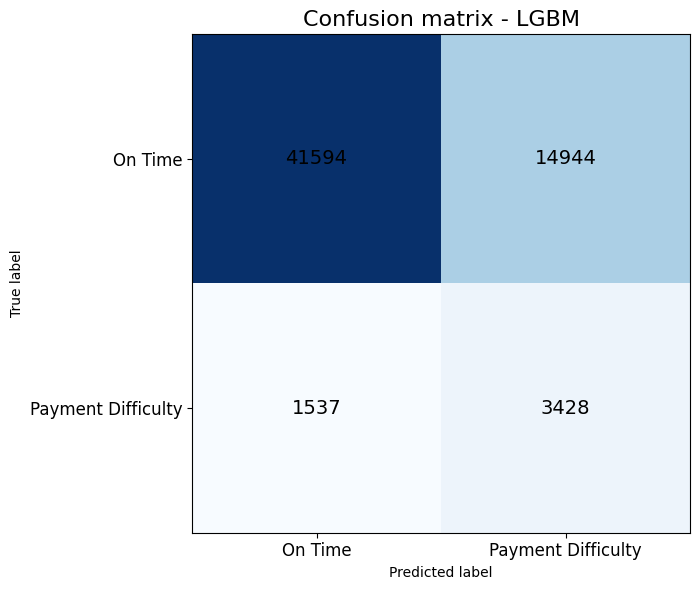

In [84]:
fig, ax = conf_mat_plot(y_test, lgbm_test_final, title="Confusion matrix - LGBM")

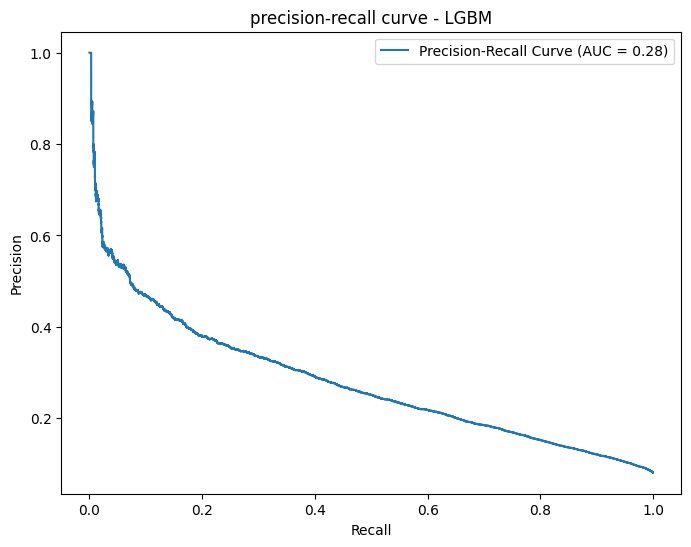

In [85]:
lgbm_probs = lgbm_modelv3.predict_proba(X_test)
lgbm_precision, lgbm_recall, lgbm_thresholds, lgbm_auc_score = plot_pr_curve(
    y_test, lgbm_probs[:, 1], title="precision-recall curve - LGBM"
)

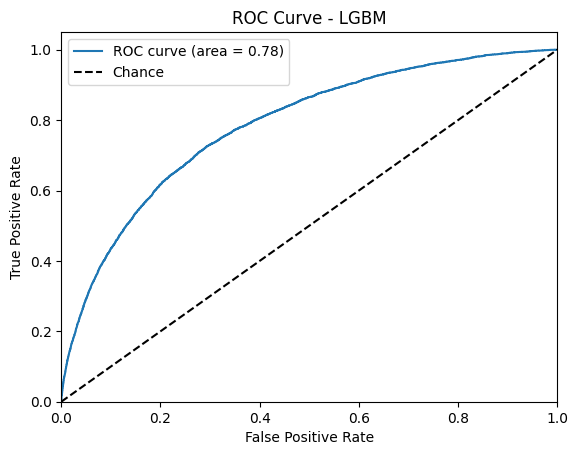

In [86]:
lgbm_fpr, lgbm_tpr, lgbm_thresh, lgbm_roc_auc = plot_roc_curve(
    y_test, lgbm_probs[:, 1], title="ROC Curve - LGBM"
)

## Logistic Regression 

In [87]:
log_reg_study.best_params

{'categorical_strategy': 'constant',
 'numerical_strategy': 'constant',
 'drop': 'if_binary',
 'smooth': 5.744779833081635,
 'with_mean': True,
 'with_std': True,
 'percentile': 99,
 'penalty': 'elasticnet',
 'tol': 2.6435350311350403e-05,
 'C': 0.0034459310919273374,
 'solver': 'saga',
 'max_iter': 700,
 'l1_ratio': 0.21825388786506417}

The best model:
- did not drop the first value, but only if binary (I didn't use many one hot encoders, I used more frequency encoding)
- kept most of the features 
- applied about 50/50 L1 to L2 regularization, quite strongly (as indicated by low C) 

In [88]:
log_reg_test_final = log_reg_modelv3.predict(X_test)
log_reg_test_performance_final = model_assessment(y_test, log_reg_test_final)

AUC-ROC: 0.6930752933700501
Accuracy: 0.699006552525893
F1-Score: 0.26899383983572894
Precision: 0.16729701851760892
Recall: 0.6860020140986909


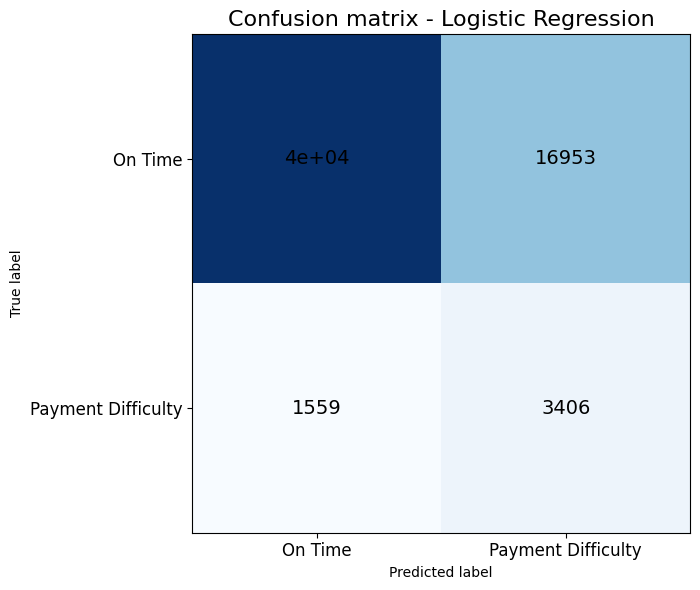

In [89]:
fig, ax = conf_mat_plot(
    y_test, log_reg_test_final, title="Confusion matrix - Logistic Regression"
)

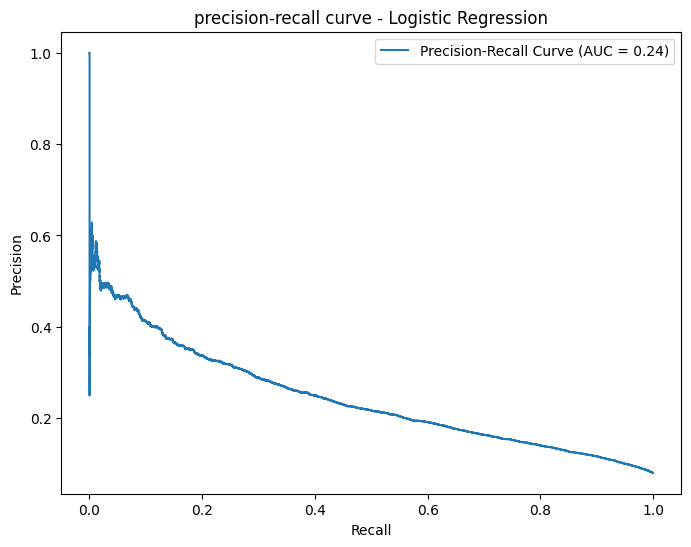

In [90]:
log_reg_probs = log_reg_modelv3.predict_proba(X_test)
log_reg_precision, log_reg_recall, log_reg_thresholds, log_reg_auc_score = (
    plot_pr_curve(
        y_test,
        log_reg_probs[:, 1],
        title="precision-recall curve - Logistic Regression",
    )
)

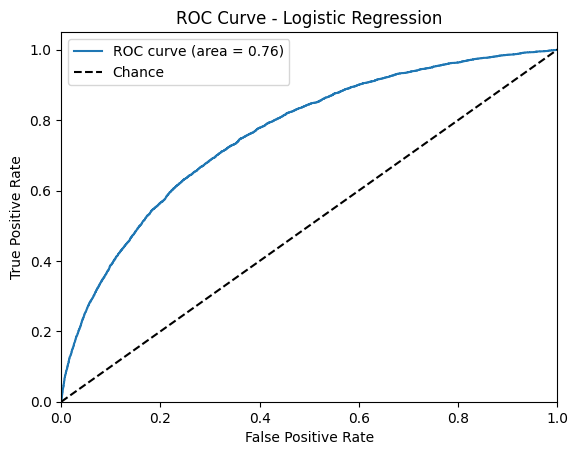

In [91]:
log_reg_fpr, log_reg_tpr, log_reg_thresh, log_reg_roc_auc = plot_roc_curve(
    y_test, log_reg_probs[:, 1], title="ROC Curve - Logistic Regression"
)

## Random Forest - Optuna optimized model

In [92]:
rf_study.best_params

{'categorical_strategy': 'constant',
 'numerical_strategy': 'constant',
 'drop': 'first',
 'smooth': 7.763398524130438,
 'with_mean': True,
 'with_std': False,
 'percentile': 39,
 'n_estimators': 1942,
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 0.10077800137742665,
 'min_samples_leaf': 0.018221825651549728,
 'max_features': 'log2'}

The best random forest model:
- required about 10% of samples to make a split
- used much fewer features (39%) 
- used nearly 2000 trees 
- did used the drop 'first' strategy (suprisingly a more commons strategy for avoiding multicolinearity in the case of linear models)

In [93]:
rf_test_final = rf_modelv3.predict(X_test)
rf_test_performance_final = model_assessment(y_test, rf_test_final)

AUC-ROC: 0.6733099594861152
Accuracy: 0.6761783978017333
F1-Score: 0.2503763926528154
Precision: 0.15396009813451836
Recall: 0.6698892245720041


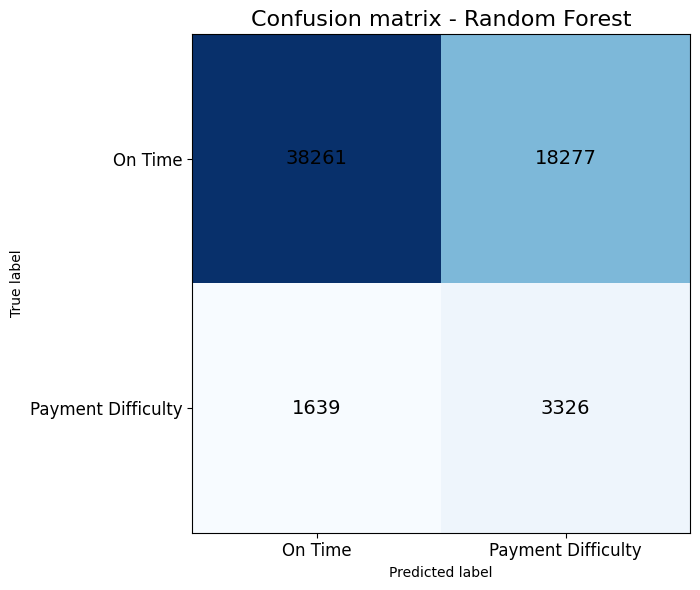

In [94]:
fig, ax = conf_mat_plot(y_test, rf_test_final, title="Confusion matrix - Random Forest")

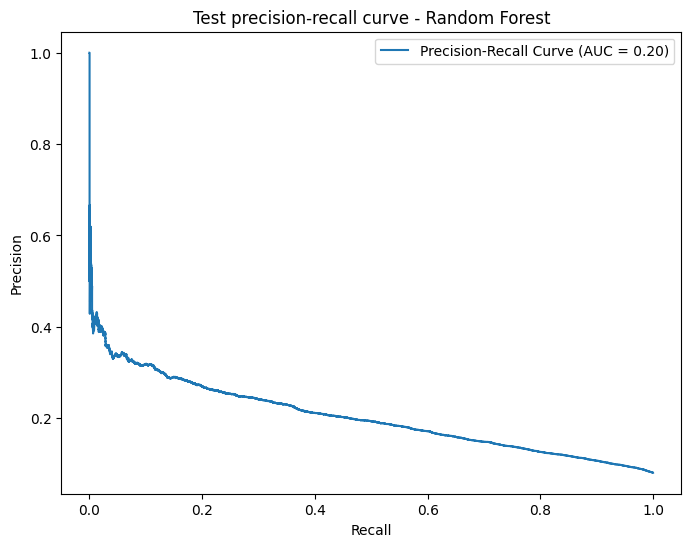

In [95]:
rf_probs = rf_modelv3.predict_proba(X_test)
rf_precision, rf_recall, rf_thresholds, rf_auc_score = plot_pr_curve(
    y_test, rf_probs[:, 1], title="Test precision-recall curve - Random Forest"
)

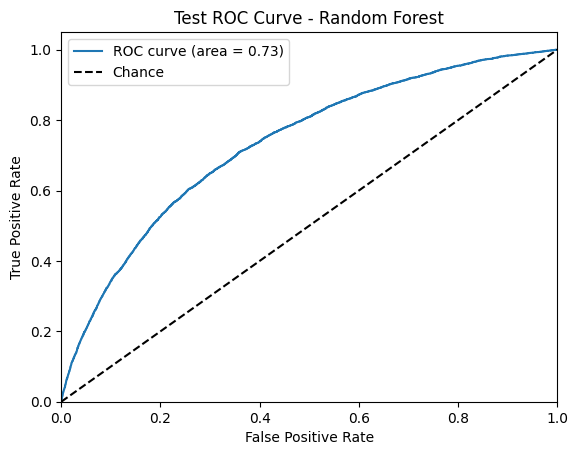

In [96]:
rf_fpr, rf_tpr, rf_thresh, rf_roc_auc = plot_roc_curve(
    y_test, rf_probs[:, 1], title="Test ROC Curve - Random Forest"
)

In [97]:
voting_model = VotingClassifier(
    estimators=[
        ("lgbm", lgbm_modelv3),
        ("log_reg", log_reg_modelv3),
        ("rf", rf_modelv3),
    ],
    voting="soft",
    n_jobs=-1,
)

In [98]:
voting_model.fit(X_train, y_train)
voting_model_train_pred = voting_model.predict(X_train)
voting_model_train_perfomance = model_assessment(y_train, voting_model_train_pred)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC-ROC: 0.730973608113225
Accuracy: 0.723463715537128
F1-Score: 0.30168343256004926
Precision: 0.18946621970087674
Recall: 0.7399295065458208


In [99]:
voting_model_val_pred = voting_model.predict(X_val)
voting_model_val_perfomance = model_assessment(y_val, voting_model_val_pred)

AUC-ROC: 0.7027435582128181
Accuracy: 0.7139953660420308
F1-Score: 0.2801309596889707
Precision: 0.17578325629173086
Recall: 0.68932527693857


In [100]:
voting_model_test_pred = voting_model.predict(X_test)
voting_model_test_perfomance = model_assessment(y_test, voting_model_test_pred)

AUC-ROC: 0.7065769897934593
Accuracy: 0.7174121587564835
F1-Score: 0.28383055876050767
Precision: 0.17841786250841837
Recall: 0.693655589123867


Ultimately this voting model underperforms Light GBM on its own (and it runs slower), so the model that I will deploy will be Light GBM. 

## Feature Analysis of Final Model (Optimized Light GBM) using SHAP

In [101]:
processed_X_train = lgbm_modelv3[:-1].transform(X_train)
processed_X_val = lgbm_modelv3[:-1].transform(X_val)
processed_X_test = lgbm_modelv3[:-1].transform(X_test)

In [102]:
lgbm_explainer = shap.TreeExplainer(lgbm_modelv3[-1])

In [103]:
shap_values_train = lgbm_explainer(processed_X_train)
shap_values_val = lgbm_explainer(processed_X_val)
shap_values_test = lgbm_explainer(processed_X_test)

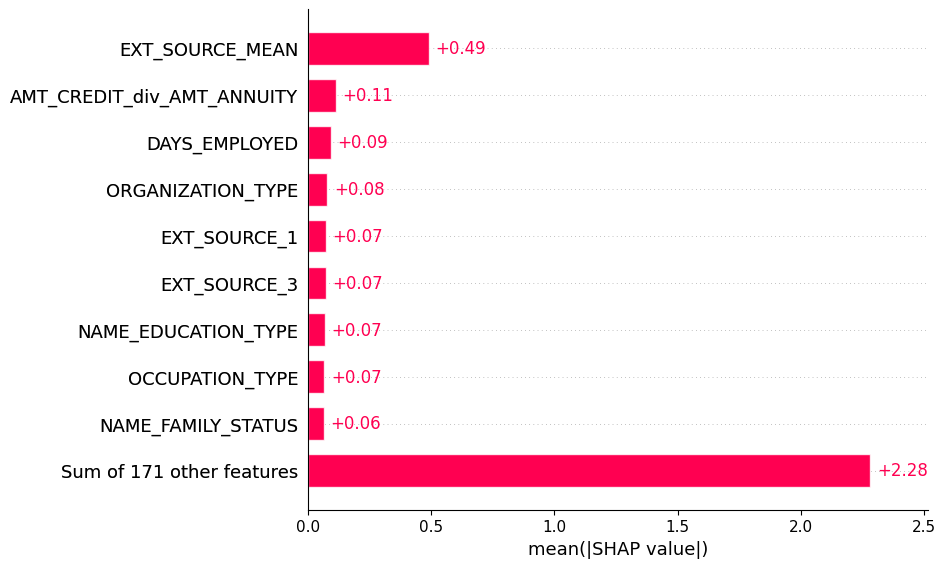

In [104]:
shap.plots.bar(shap_values_test)

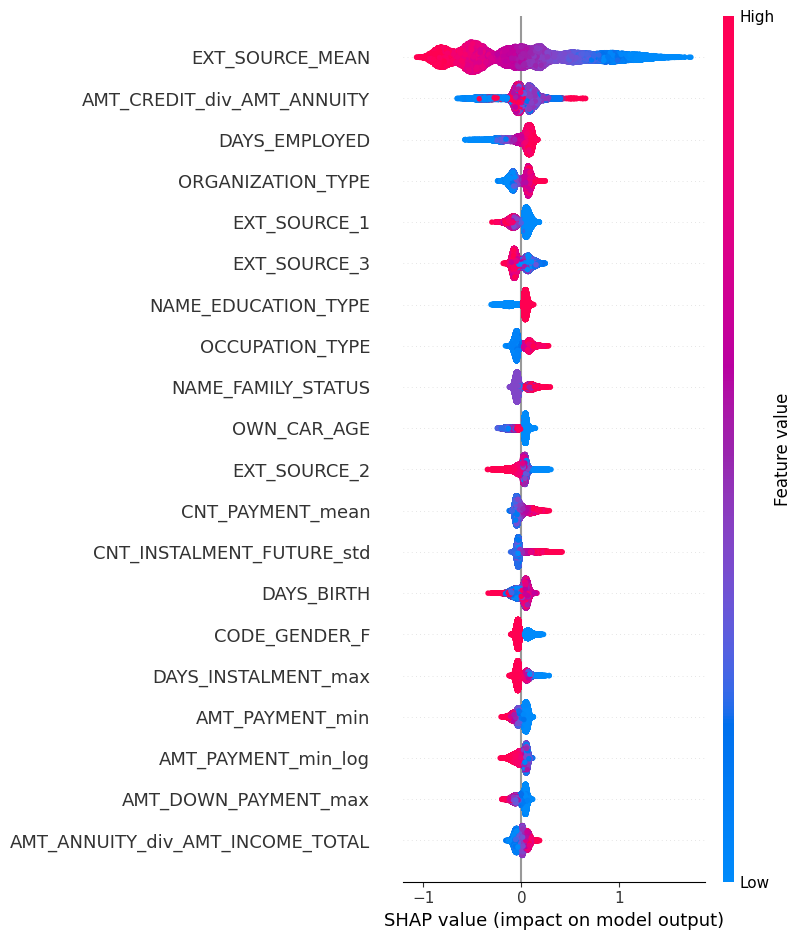

In [105]:
shap.summary_plot(shap_values_test)

__Data Preparation for Kaggle Competition__

As a final task, let's prepare an entry for the expired [Kaggle competition](https://www.kaggle.com/competitions/home-credit-default-risk/overview) that uses this dataset to see how my model compares to other professionals. 

In [106]:
lgbm_model_kaggle_testpredv3 = lgbm_modelv3.predict_proba(X=kaggle_X_test)
kaggle_target_preds = lgbm_model_kaggle_testpredv3[:, 1]
id = kaggle_X_test.reset_index()["SK_ID_CURR"]
id = pd.DataFrame(id, columns=["SK_ID_CURR"])
lgbm_model_kaggle_testpredv3 = pd.DataFrame(
    lgbm_model_kaggle_testpredv3[:, 1], columns=["TARGET"]
)
homecredit_submission = pd.concat([id, lgbm_model_kaggle_testpredv3], axis=1)
homecredit_submission

,SK_ID_CURR,TARGET
0,100001,0.29377
1,100005,0.57116
2,100013,0.27362
3,100028,0.25887
4,100038,0.76556
...,...,...
48739,456221,0.35434
48740,456222,0.46184
48741,456223,0.05764
48742,456224,0.31258


In [107]:
homecredit_submission.to_csv(
    "../data/kaggle_submission/homecredit_submission.csv", index=False
)

Submission to Kaggle
AUC_ROC 0.77804

# Notebook Conclusions
- external sources, the credit annuity ratio, and job related information are important features 
- Even my best model is likely to miss 30% of people who will default 
- However, we can shift the model's threshold to protect for this. By being more strict with what we call "no default", we can have a stronger assumption that people will default. It will decrease the number of loans given out, but it will also decrease risk.

Technically:

- LightGBM slightly outperforms logistic regression and random forest
- Hyperparameter tuning did not do much to improve models relative to less crafted versions of the same models 
- An instance-based pipeline structure allows for easy interaction with Optuna
- A reduced feature space works just fine 

Future Directions:
- consider scaling features by EXT_SOURCES, or otherwise working this feature into newly engineered features
- hyperparameter tune using the whole dataset (perhaps using a cluster or GPU for computing power) 
- try more varieties of models
- use a smaller dataset in order to create a model that users could interact with more directly (e.g. put in a few features and get the probability of getting a loan back to them) 

## Prepare Materials for Deployment

In [228]:
lgbm_best_trial = lgbm_study.best_trial
final_model = instantiate_lgbm_model(lgbm_best_trial, X=X_train, y=y_train)
final_model.set_output(transform="pandas")
final_model.fit(X_train, y_train)

/Users/migueldiaz/home-credit/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_imputation',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant'),
                                                  []),
                                                 ('numerical_imputation',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_CREDIT_div_AMT_ANNUITY',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_ANNUITY_div_AMT_INCOME_TOTAL...
                                bagging_freq=1,
                                feature_fraction=0.851083221228567,
                                lambda_l1=0.0038076305560719886,
                                lambda_l2=0.0006326300655566424,
                                learning_rate=0.017720500819766883,
                                max_depth=12, metric=['auc', 'binary_logloss'],
                                min_child_samples=81,
                                min_split_gain=0.14162524181784342,
                                n_estimators=405, num_leaves=52,
                                objective='binary',
                                scale_pos_weight=np.float64(11.387084592145015),
                                verbosity=-1))])

In [229]:
with open("../deployment/model/model.pkl", "wb") as file:
    pickle.dump(final_model, file)

In [191]:
X_complete = pd.concat([X_train, X_val, X_test], axis=0)
X_complete = X_complete.sort_index()
X_complete.to_parquet(path="../deployment/data/X_data.parquet", index=True)

In [225]:
X_read = pd.read_parquet("../deployment/data/X_data.parquet")

# Interact with Deployed App

In [277]:
import requests 

url = "https://home-credit-375961790011.us-east4.run.app"
response = requests.get(url)

In [278]:
if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print("Request failed with status code:", response.status_code)

{'message': 'Loan default prediction API is running'}


In [281]:
url = "http://localhost:80/predict"

input_data = {
  "AMT_CREDIT": 100000,
  "AMT_ANNUITY": 0,
  "AMT_CREDIT_div_AMT_ANNUITY": 0,
  "AMT_INCOME_TOTAL": 0,
  "AMT_ANNUITY_div_AMT_INCOME_TOTAL": 0,
  "AMT_ANNUITY_log": 0,
  "AMT_ANNUITY_log_div_AMT_INCOME_TOTAL": 0,
  "HOUR_APPR_PROCESS_START_sin": 0,
  "FLAG_DOCUMENT_2": True,
  "FLAG_DOCUMENT_3": True,
  "FLAG_DOCUMENT_4": True,
  "FLAG_DOCUMENT_5": True,
  "FLAG_DOCUMENT_6": True,
  "FLAG_DOCUMENT_7": True,
  "FLAG_DOCUMENT_8": True,
  "FLAG_DOCUMENT_9": True,
  "FLAG_DOCUMENT_10": True,
  "FLAG_DOCUMENT_11": True,
  "FLAG_DOCUMENT_12": True,
  "FLAG_DOCUMENT_13": True,
  "FLAG_DOCUMENT_14": True,
  "FLAG_DOCUMENT_15": True,
  "FLAG_DOCUMENT_16": True,
  "FLAG_DOCUMENT_17": True,
  "FLAG_DOCUMENT_18": True,
  "FLAG_DOCUMENT_19": True,
  "FLAG_DOCUMENT_21": True,
  "nFLAGS_ALL_ZEROS": True,
  "EXT_SOURCE_1": 0,
  "EXT_SOURCE_2": 0,
  "EXT_SOURCE_3": 0,
  "ANY_EXT_SOURCE_MISSING": True,
  "AMT_REQ_CREDIT_BUREAU_DAY": 0,
  "AMT_REQ_CREDIT_BUREAU_HOUR": 0,
  "AMT_REQ_CREDIT_BUREAU_MON": 0,
  "AMT_REQ_CREDIT_BUREAU_QRT": 0,
  "AMT_REQ_CREDIT_BUREAU_WEEK": 0,
  "AMT_REQ_CREDIT_BUREAU_YEAR": 0,
  "EXT_SOURCE_MEAN": 0,
  "EXT_SOURCE_STD": 0,
  "DAYS_EMPLOYED": 0,
  "AMT_PAYMENT_min": 0,
  "CNT_INSTALMENT_FUTURE_std": 0,
  "n_old_credit_balances_log": 0,
  "n_prev_apps_log": 0,
  "n_prev_payments_log": 0,
  "AMT_PAYMENT_min_log": 0,
  "DAYS_CREDIT_max": 0,
  "DAYS_CREDIT_UPDATE_mean": 0,
  "DAYS_INSTALMENT_max": 0,
  "DAYS_CREDIT_ENDDATE_mean_log": 0,
  "NAME_CONTRACT_TYPE": "string",
  "CODE_GENDER": "string",
  "FLAG_OWN_CAR": True,
  "FLAG_OWN_REALTY": True,
  "CNT_CHILDREN": 0,
  "NAME_TYPE_SUITE": "string",
  "NAME_EDUCATION_TYPE": "string",
  "NAME_FAMILY_STATUS": "string",
  "NAME_HOUSING_TYPE": "string",
  "REGION_POPULATION_RELATIVE": 0,
  "DAYS_BIRTH": 0,
  "DAYS_REGISTRATION": 0,
  "DAYS_ID_PUBLISH": 0,
  "OWN_CAR_AGE": 0,
  "FLAG_MOBIL": True,
  "FLAG_WORK_PHONE": True,
  "FLAG_CONT_MOBILE": True,
  "FLAG_PHONE": True,
  "FLAG_EMAIL": True,
  "OCCUPATION_TYPE": "string",
  "REGION_RATING_CLIENT": 0,
  "WEEKDAY_APPR_PROCESS_START": "string",
  "REG_REGION_NOT_LIVE_REGION": True,
  "LIVE_REGION_NOT_WORK_REGION": True,
  "REG_CITY_NOT_LIVE_CITY": True,
  "REG_CITY_NOT_WORK_CITY": True,
  "ORGANIZATION_TYPE": "string",
  "YEARS_BUILD_AVG": 0,
  "ENTRANCES_AVG": 0,
  "FLOORSMAX_AVG": 0,
  "LANDAREA_AVG": 0,
  "NONLIVINGAPARTMENTS_AVG": 0,
  "NONLIVINGAREA_AVG": 0,
  "BASEMENTAREA_MODE": 0,
  "YEARS_BEGINEXPLUATATION_MODE": 0,
  "LIVINGAPARTMENTS_MODE": 0,
  "COMMONAREA_MEDI": 0,
  "FONDKAPREMONT_MODE": "string",
  "HOUSETYPE_MODE": "string",
  "WALLSMATERIAL_MODE": "string",
  "EMERGENCYSTATE_MODE": "string",
  "OBS_30_CNT_SOCIAL_CIRCLE": 0,
  "DEF_30_CNT_SOCIAL_CIRCLE": 0,
  "DAYS_LAST_PHONE_CHANGE": 0,
  "AMT_ANNUITY_max_x": 0,
  "AMT_CREDIT_MAX_OVERDUE_max": 0,
  "AMT_CREDIT_MAX_OVERDUE_std": 0,
  "AMT_CREDIT_SUM_median": 0,
  "AMT_CREDIT_SUM_DEBT_max": 0,
  "AMT_CREDIT_SUM_DEBT_std": 0,
  "AMT_CREDIT_SUM_LIMIT_max": 0,
  "AMT_CREDIT_SUM_LIMIT_mean": 0,
  "AMT_CREDIT_SUM_OVERDUE_max": 0,
  "CREDIT_DAY_OVERDUE_std": 0,
  "DAYS_CREDIT_min": 0,
  "DAYS_CREDIT_std": 0,
  "DAYS_CREDIT_ENDDATE_min": 0,
  "DAYS_CREDIT_ENDDATE_max": 0,
  "DAYS_CREDIT_UPDATE_max": 0,
  "DAYS_ENDDATE_FACT_max": 0,
  "MONTHS_BALANCE_mean_mean": 0,
  "STATUS_1_cts_max": 0,
  "STATUS_1_cts_mean": 0,
  "STATUS_1_cts_std": 0,
  "CREDIT_ACTIVE_Active_cts": 0,
  "CREDIT_TYPE_Consumer_credit_cts": 0,
  "CREDIT_TYPE_Credit_card_cts": 0,
  "CREDIT_TYPE_Microloan_cts": 0,
  "CREDIT_TYPE_Mortgage_cts": 0,
  "AMT_CREDIT_LIMIT_ACTUAL_median": 0,
  "AMT_CREDIT_LIMIT_ACTUAL_std": 0,
  "AMT_DRAWINGS_ATM_CURRENT_max": 0,
  "AMT_DRAWINGS_ATM_CURRENT_mean": 0,
  "AMT_DRAWINGS_CURRENT_std": 0,
  "AMT_DRAWINGS_POS_CURRENT_mean": 0,
  "AMT_DRAWINGS_POS_CURRENT_std": 0,
  "AMT_PAYMENT_TOTAL_CURRENT_max": 0,
  "AMT_RECEIVABLE_PRINCIPAL_max": 0,
  "AMT_RECIVABLE_min": 0,
  "AMT_RECIVABLE_median": 0,
  "CNT_DRAWINGS_ATM_CURRENT_mean": 0,
  "CNT_DRAWINGS_ATM_CURRENT_std": 0,
  "CNT_DRAWINGS_CURRENT_max": 0,
  "CNT_DRAWINGS_CURRENT_mean": 0,
  "CNT_INSTALMENT_MATURE_CUM_min": 0,
  "CNT_INSTALMENT_MATURE_CUM_std": 0,
  "MONTHS_BALANCE_max_x": 0,
  "CNT_INSTALMENT_min": 0,
  "CNT_INSTALMENT_FUTURE_median": 0,
  "MONTHS_BALANCE_std": 0,
  "SK_DPD_std": 0,
  "SK_DPD_DEF_max": 0,
  "NAME_CONTRACT_STATUS_Active_cts": 0,
  "NAME_CONTRACT_STATUS_Completed_cts": 0,
  "AMT_ANNUITY_max_y": 0,
  "AMT_ANNUITY_mean": 0,
  "AMT_CREDIT_median": 0,
  "AMT_CREDIT_std": 0,
  "AMT_DOWN_PAYMENT_max": 0,
  "CNT_PAYMENT_max": 0,
  "CNT_PAYMENT_mean": 0,
  "CNT_PAYMENT_std": 0,
  "DAYS_DECISION_min": 0,
  "DAYS_DECISION_mean": 0,
  "DAYS_DECISION_std": 0,
  "DAYS_FIRST_DRAWING_std": 0,
  "DAYS_FIRST_DUE_min": 0,
  "DAYS_FIRST_DUE_std": 0,
  "DAYS_LAST_DUE_1ST_VERSION_median": 0,
  "DAYS_TERMINATION_mean": 0,
  "HOUR_APPR_PROCESS_START_min": 0,
  "RATE_DOWN_PAYMENT_max": 0,
  "RATE_DOWN_PAYMENT_std": 0,
  "SELLERPLACE_AREA_max": 0,
  "NAME_CONTRACT_STATUS_Approved_cts": 0,
  "CODE_REJECT_REASON_HC_cts": 0,
  "CODE_REJECT_REASON_LIMIT_cts": 0,
  "CODE_REJECT_REASON_SCOFR_cts": 0,
  "NAME_CLIENT_TYPE_New_cts": 0,
  "NAME_CLIENT_TYPE_Refreshed_cts": 0,
  "NAME_GOODS_CATEGORY_Furniture_cts": 0,
  "NAME_GOODS_CATEGORY_Mobile_cts": 0,
  "NAME_PORTFOLIO_Cards_cts": 0,
  "NAME_PRODUCT_TYPE_walk_in_cts": 0,
  "CHANNEL_TYPE_AP___Cash_loan__cts": 0,
  "NAME_SELLER_INDUSTRY_Auto_cts": 0,
  "NAME_SELLER_INDUSTRY_Consumer_electronics_cts": 0,
  "NAME_SELLER_INDUSTRY_Furniture_cts": 0,
  "CNT_PAYMENT_max_y": 0,
  "NAME_CONTRACT_STATUS_Refused_cts": 0,
  "NAME_SELLER_INDUSTRY_XNA_cts": 0,
  "NAME_YIELD_GROUP_high_cts": 0,
  "NAME_YIELD_GROUP_low_action_cts": 0,
  "NAME_YIELD_GROUP_low_normal_cts": 0,
  "PRODUCT_COMBINATION_Cash_Street__high_cts": 0,
  "PRODUCT_COMBINATION_Cash_Street__middle_cts": 0,
  "PRODUCT_COMBINATION_Cash_X_Sell__high_cts": 0,
  "PRODUCT_COMBINATION_Cash_X_Sell__low_cts": 0,
  "PRODUCT_COMBINATION_POS_industry_with_interest_cts": 0,
  "PRODUCT_COMBINATION_POS_industry_without_interest_cts": 0,
  "PRODUCT_COMBINATION_POS_mobile_with_interest_cts": 0,
  "AMT_PAYMENT_max": 0,
  "AMT_PAYMENT_std": 0,
  "NUM_INSTALMENT_NUMBER_std": 0,
  "NUM_INSTALMENT_VERSION_min": 0,
  "NUM_INSTALMENT_VERSION_max": 0,
  "NUM_INSTALMENT_VERSION_mean": 0
}
response = requests.post(url, json=input_data)

print(response.json())

{'default_proba': 0.7505951436322541}
